# Introduction
This notebook covers exploratory clustering of breast cancer RNA-Seq data from the [TCGA](http://cancergenome.nih.gov/).  I used [UMAP](https://umap-learn.readthedocs.io/en/latest/) to reduce the dimensionality and then hierarchical density clustering with [HDBSCAN](). Kaplan-Meier estimators are used to determine if the overall survival of the clusters are different.

Some caveats:
* Reproducibility. The data from the TCGA were provided by a colleague, however I would like to update the notebook with code to download the data directly so that the analysis can be performed by anyone
* This notebook is a work in progress — I'd really like to polish it into something clearer and more useful 
* It does not examine different possible clusterings from varying the clustering algorithm's hyperparameters
* The overall survival for each cluster is compared with *all* other individuals (comparison between two groups) to test for significantly different clusters. No attempt was made to find a set of clusters with significantly different survival
* It's not surprising that clusters of significantly different overall survival were found. See, for example: D Venet, J E. Dumont, V Detours ["Most Random Gene Expression Signatures Are Significantly Associated with Breast Cancer Outcome"](https://doi.org/10.1371/journal.pcbi.1002240)
---

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN, dist_metrics
from hdbscan.validity import validity_index
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from IPython.display import display
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test, pairwise_logrank_test
%matplotlib inline

# Load data

In [2]:
# Load expression data into Pandas DataFrame
FILE = 'data/tcgaexp'
df_expression = pd.read_table(FILE, sep=' ').transpose()

# Truncate index to first 15 characters to match clinical data files
df_expression.index = df_expression.index.str[0:15]
print(df_expression.shape[0], 'patients,', df_expression.shape[1], 'genes')

1208 patients, 24332 genes


In [3]:
# Load metadata into Pandas DataFrame
FILE = 'data/TCGAclin.csv'
df_meta = pd.read_csv(FILE, index_col=0)

# Truncate index to first 15 characters to match clinical data files
df_meta.index = df_meta.index.str[0:15]

# Check indices match up
print('Matching indices:', (df_expression.index == df_meta.index).sum())

Matching indices: 1208


In [4]:
# Load selected clinical columns
# 'breast_carcinoma_estrogen_receptor_status' and 'breast_carcinoma_progesterone_receptor_status' cover more samples 
# than the data in TCGAclin.csv 
FILE = 'data/BRCA_clinicalMatrix'
columns = ['sampleID', 'ER_Status_nature2012', 
           'breast_carcinoma_estrogen_receptor_status','breast_carcinoma_progesterone_receptor_status',
           'lab_proc_her2_neu_immunohistochemistry_receptor_status',
           'PAM50Call_RNAseq', 'PAM50_mRNA_nature2012', 
           'OS_Time_nature2012', 'OS_event_nature2012', 'OS.time', 'OS', 'OS.unit', 
           'RFS.time', 'RFS', 'RFS.unit','age_at_initial_pathologic_diagnosis']
df_clinical = pd.read_table(FILE, index_col=0, usecols=columns)
df_clinical.shape

(1247, 15)

In [5]:
# There are more samples in the clincal data - do an inner join to select only matching samples
df_tmp = pd.DataFrame(index=df_expression.index)
df_clinical = pd.merge(df_tmp, df_clinical, how='inner', left_index=True, right_index=True)
df_clinical.shape

(1208, 15)

In [6]:
# Sort dataframes so they align
df_expression.sort_index(inplace=True)
df_meta.sort_index(inplace=True)
df_clinical.sort_index(inplace=True)

In [7]:
# Check indices match
(df_expression.index == df_clinical.index).sum(), (df_meta.index == df_clinical.index).sum()

(1208, 1208)

# Clustering

Usual UMAP+HDBSCAN clustering. No systematic optimisation of the hyperparameters, just one that gives sensible and interesting results.

In [8]:
# Use same metric for UMAP and HDBSCAN
metric = 'correlation'

In [9]:
# Note: min_dist=0.0 recommended for clustering 
# (see https://umap-learn.readthedocs.io/en/latest/clustering.html#umap-enhanced-clustering)
umap = UMAP(n_components=200, n_neighbors=15, min_dist=0.0, metric=metric, random_state=42)
X_umap = umap.fit_transform(df_expression)
X_umap.shape

(1208, 200)

In [10]:
cluster = HDBSCAN(min_cluster_size=20, min_samples=20, alpha=1.0, cluster_selection_method='leaf', 
                  metric='correlation', gen_min_span_tree=True, algorithm='best')
cluster.fit(X_umap)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='leaf',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='correlation', min_cluster_size=20, min_samples=20, p=None,
    prediction_data=False)

# Cluster summary

In [11]:
n_samples = df_expression.shape[0]
df_tree = cluster.condensed_tree_.to_pandas()
print('Total clusters (including subclusters): {}'.format(len(df_tree['parent'].unique())))

Total clusters (including subclusters): 19


In [17]:
# Get sample ids for a list of cluster ids
# Must set cluster_labels = [] before calling the function
# Should create a lightweight class
cluster_labels = []
def get_cluster_labels(ids):
    global cluster_labels
    
    ids = df_tree.query('parent in @ids')['child'].values
    
    ids1 = ids[ids >= n_samples]
    ids2 = ids[ids < n_samples]

    cluster_labels += list(ids2)
    
    if len(ids1) == 0:
        return cluster_labels
    else:
        return get_cluster_labels(ids1)

In [12]:
# Create summary dataframe
n_clusters = len(df_tree['parent'].unique())
print('Total clusters in the hierarchy: {}'.format(n_clusters))

columns = ['Children', 'Samples', 'Age (diagnosis)',
           'ER+ fraction', 'ER+ II fraction', 'PR+ fraction', 
           'PR+ II fraction', 'HER2+ fraction', 'TN fraction', 
           'Basal (PAM50)', 'Her2 (PAM50)', 'LumA (PAM50)', 'LumB (PAM50)', 
           'Normal (PAM50)',
           'OS median (years)', 'OS p-value', 'RFS median (years)', 'RFS p-value']
df_summary = pd.DataFrame(index=df_tree['parent'].unique(), columns=columns)

Total clusters in the hierarchy: 19


In [13]:
def get_receptor_fraction(labels, receptor_column, positive_value, df):
    """Get the fraction of samples in a cluster with a positive value
    This is number of samples that are positive divided by total number of samples, but ignoring NAs"""
    values = df.iloc[labels][receptor_column].dropna() == positive_value
    return values.mean(), values.count()

In [14]:
def survival_analysis(labels, survival_type='OS'):
    """Analyse the inputed cluster vs. all other samples 
    labels are a list of integer values representing the samples in a cluster"""

    # True/False mask for the cluster
    mask = np.zeros((n_samples), dtype=np.bool)
    mask[labels] = True
    
    if survival_type == 'OS':        
        event_times = df_clinical['OS.time']
        event_observed = df_clinical['OS']
    else:
        event_times = df_clinical['RFS.time']
        event_observed = df_clinical['RFS']        
    
    # Fit Kaplan Meier 
    kmf = KaplanMeierFitter()
    kmf.fit(event_times[mask].dropna().values/365, 
            event_observed[mask].dropna().values, label=cl)

    # Note: logrank_test() handles NaNs in the survival data (OS, OS.time, etc)
    result = logrank_test(event_times[mask].values/365, event_times[~mask].values/365, 
                          event_observed[mask].values, event_observed[~mask].values,
                          alpha=0.95)
    return kmf, result.p_value

In [15]:
def get_subclusters(cluster_id):
    """Get pair of subclusters from a cluster index. 
    Clusters in the hierarchy have either two children (subclusters) or no children"""
    
    children = df_tree.query('parent == @cluster_id')['child']
    mask = (children >= n_samples)
    if mask.sum() == 2:
        return tuple(children[mask])
    else:
        return (None, None)

In [18]:
# Populate summary dataframe

# dicts to store Kaplan-Meier objects
os = {}
rfs = {}

# Loop over all the clusters in the hierarchy
for cl in df_tree['parent'].unique():
#for cl in [1223]:
    
    # Get labels for this cluster
    cluster_labels = []  
    cluster_labels = get_cluster_labels([cl])

    # Number of samples in this cluster and cluster children
    df_summary.loc[cl, 'Samples'] = len(cluster_labels)
    df_summary.loc[cl, 'Children'] = '{},{}'.format(*get_subclusters(cl))
    
    # Age at diagnosis    
    df_summary.loc[cl, 'Age (diagnosis)'] = df_clinical.iloc[cluster_labels]['age_at_initial_pathologic_diagnosis'].mean() 

    # Receptor fractions
    df_summary.loc[cl, 'ER+ fraction'] = get_receptor_fraction(cluster_labels, 'ER', 'Pos', df_meta)[0]
    
    df_summary.loc[cl, 'ER+ II fraction'] = get_receptor_fraction(cluster_labels, 
                                                                  'breast_carcinoma_estrogen_receptor_status',
                                                                  'Positive', df_clinical)[0]
    df_summary.loc[cl, 'PR+ fraction'] = get_receptor_fraction(cluster_labels, 'PR', 'Pos', df_meta)[0]
    df_summary.loc[cl, 'PR+ II fraction'] = get_receptor_fraction(cluster_labels, 
                                                                  'breast_carcinoma_progesterone_receptor_status', 
                                                                  'Positive', df_clinical)[0]
    df_summary.loc[cl, 'HER2+ fraction'] = get_receptor_fraction(cluster_labels, 'HER2', 'Pos', df_meta)[0]
    df_summary.loc[cl, 'TN fraction'] = get_receptor_fraction(cluster_labels, 'trip_neg', 1, df_meta)[0]
    
    # PAM50
    values = df_meta.iloc[cluster_labels]['PAM50'].dropna() 
    for i, PAM50_type in enumerate(np.unique(df_meta['PAM50'])):
        df_summary.loc[cl][PAM50_type+' (PAM50)'] = (values == PAM50_type).mean()
    
    # Kaplan-Meier and p-values
    # Overall survival
    kmf, p = survival_analysis(cluster_labels, survival_type='OS')
    os[cl] = kmf
    df_summary.loc[cl, 'OS p-value'] = p
    df_summary.loc[cl, 'OS median (years)'] = kmf.median_
    
    # Relapse-free survival
    kmf, p = survival_analysis(cluster_labels, survival_type='RFS')
    rfs[cl] = kmf
    df_summary.loc[cl, 'RFS p-value'] = p
    df_summary.loc[cl, 'RFS median (years)'] = kmf.median_

In [19]:
# Summary data for all clusters and subclusters
df_summary.style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1208,"1209,1210",1208,58.22,0.77,0.77,0.67,0.67,0.14,0.11,0.19,0.13,0.28,0.24,0.16,10.05,nan,inf,nan
1209,"1211,1212",1022,58.79,0.90,0.89,0.79,0.78,0.16,0.03,0.04,0.15,0.33,0.29,0.19,9.51,0.25,inf,0.48
1210,"1215,1216",186,55.06,0.10,0.12,0.07,0.07,0.02,0.58,1.00,0.00,0.00,0.00,0.00,20.42,0.25,inf,0.48
1211,"1217,1218",901,59.09,0.90,0.90,0.79,0.79,0.16,0.03,0.05,0.18,0.36,0.32,0.09,10.24,0.01,inf,0.83
1212,"1213,1214",121,56.55,0.80,0.80,0.60,0.69,0.00,0.01,0.02,0.00,0.07,0.00,0.91,6.90,0.00,inf,0.54
1213,"None,None",41,50.68,0.80,0.85,0.60,0.78,0.00,0.02,0.02,0.00,0.00,0.00,0.98,10.05,0.25,inf,0.44
1214,"None,None",43,63.49,nan,0.80,nan,0.66,nan,0.00,0.00,0.00,0.00,0.00,1.00,5.28,0.00,inf,0.58
1215,"None,None",29,53.76,0.11,0.08,0.17,0.12,0.06,0.48,1.00,0.00,0.00,0.00,0.00,20.42,0.15,inf,0.97
1216,"None,None",52,54.94,0.13,0.16,0.03,0.04,0.03,0.56,1.00,0.00,0.00,0.00,0.00,inf,0.40,inf,0.03
1217,"1219,1220",660,59.20,0.97,0.97,0.86,0.86,0.11,0.01,0.02,0.10,0.41,0.36,0.11,10.24,0.00,inf,0.19


# Cluster analysis
Examine the cluster hierarchy starting with whole dataset and exploring subsequent subclusters

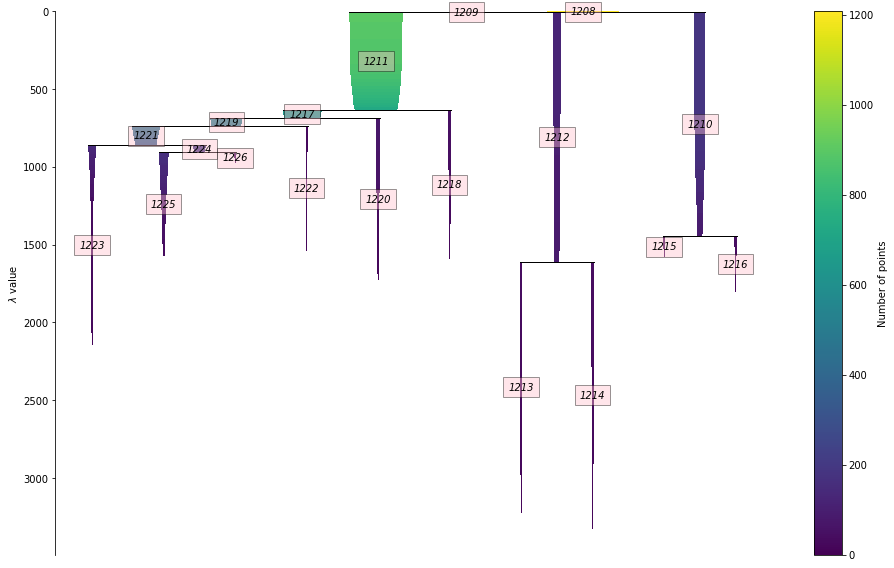

In [20]:
# Plot condensed tree with clusters labelled
# Note the clusters are numbered from n_samples (1208) upwards

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
cluster.condensed_tree_.plot(axis=ax)

cluster_bounds = cluster.condensed_tree_.get_plot_data()['cluster_bounds']
for cl in cluster_bounds:
    x = cluster_bounds[cl]
    width = x[1]-x[0]
    height = x[3]-x[2]
    ax.text(x[0]+width/2, x[2]+height/2, cl, style='italic', 
            horizontalalignment='center', verticalalignment='center',
            bbox={'facecolor':'pink', 'alpha':0.4, 'pad':5})
plt.show()

In [21]:
# All samples
df_summary.loc[[1208]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1208,"1209,1210",1208,58.22,0.77,0.77,0.67,0.67,0.14,0.11,0.19,0.13,0.28,0.24,0.16,10.05,nan,inf,nan


In [22]:
# First pair of subclusters
# 1210 is mostly PAM50 Basal and triple negative: 
df_summary.loc[[1209,1210]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1209,"1211,1212",1022,58.79,0.90,0.89,0.79,0.78,0.16,0.03,0.04,0.15,0.33,0.29,0.19,9.51,0.25,inf,0.48
1210,"1215,1216",186,55.06,0.10,0.12,0.07,0.07,0.02,0.58,1.00,0.00,0.00,0.00,0.00,20.42,0.25,inf,0.48


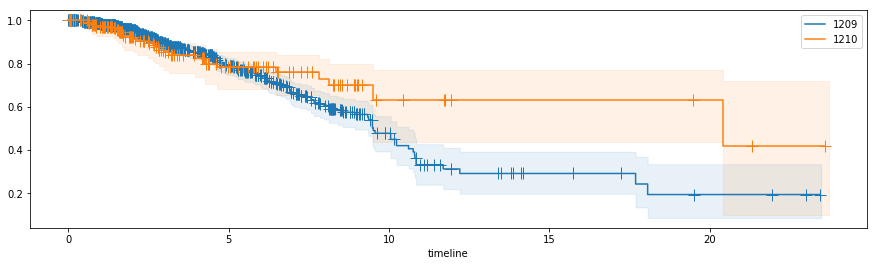

In [23]:
# Some difference in overall survival, especially after 10 years, but p = 0.25
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1209,1210]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [24]:
# Split largest remaining cluster
# 1212 is mostly PAM50 normal with significantly different overal survival:
# remaining largest cluster (1211) also has significantly different overal survival compared to all other samples
# this remaining cluster contains all the samples, except basal/TN and Normal clusters
df_summary.loc[[1211,1212]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1211,"1217,1218",901,59.09,0.90,0.90,0.79,0.79,0.16,0.03,0.05,0.18,0.36,0.32,0.09,10.24,0.01,inf,0.83
1212,"1213,1214",121,56.55,0.80,0.80,0.60,0.69,0.00,0.01,0.02,0.00,0.07,0.00,0.91,6.90,0.00,inf,0.54


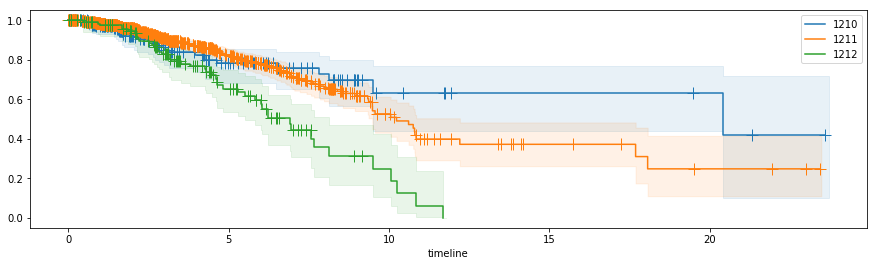

In [25]:
# Cluster 1211 has significant different OS compared to the rest 
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1210,1211,1212]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [26]:
# Split largest remaining cluster
# 1218 is mostly PAM50 Her2 and Her2 positive receptor status
# remaining largest cluster (1217) still has significantly different overall survival compared to all other samples 
# this might be expected as its parent (cluster 1211) has significantly different overall survival
df_summary.loc[[1217,1218]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1217,"1219,1220",660,59.20,0.97,0.97,0.86,0.86,0.11,0.01,0.02,0.10,0.41,0.36,0.11,10.24,0.00,inf,0.19
1218,"None,None",51,59.90,0.17,0.19,0.08,0.11,0.62,0.22,0.10,0.88,0.00,0.00,0.02,8.39,0.18,inf,0.81


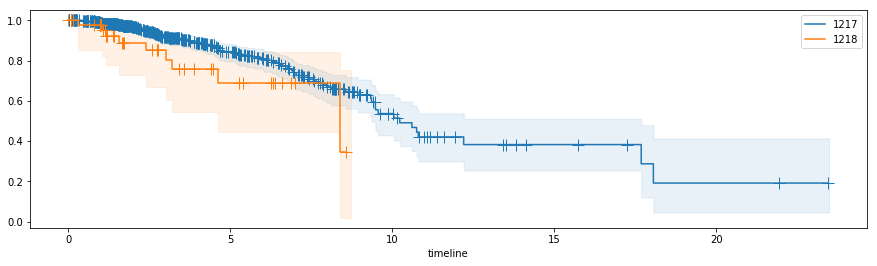

In [27]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1217,1218]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [28]:
# Split largest remaining cluster
# 1220 is less clear, mostly Luminal A with some Luminal B
# remaining largest cluster (1219) still has significantly different overal survival compared to all other samples
df_summary.loc[[1219,1220]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1219,"1221,1222",538,58.49,0.98,0.98,0.86,0.86,0.13,0.01,0.03,0.10,0.38,0.36,0.13,10.24,0.01,14.02,0.16
1220,"None,None",75,66.97,0.98,0.99,0.91,0.91,0.02,0.01,0.00,0.00,0.60,0.39,0.01,8.56,0.31,inf,0.54


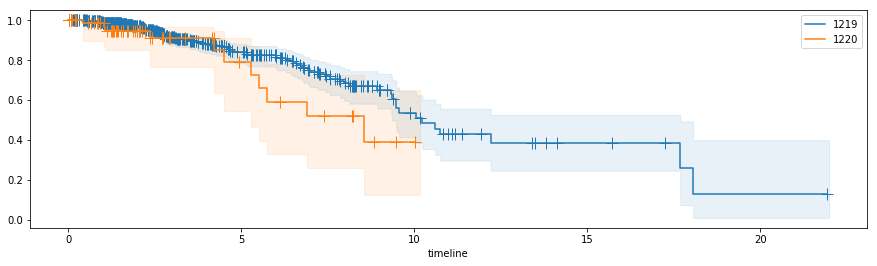

In [29]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1219,1220]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [30]:
# Split largest remaining cluster
# 1222 is less clear, mostly Luminal A, some Luminal B, Normal and Her2 - but with significantly 
# different overal survival - 100 % survival after ~10 years
# remaining largest cluster (1221) still has significantly different overal survival compared to all other samples
df_summary.loc[[1221,1222]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1221,"1223,1224",478,58.23,0.98,0.98,0.87,0.87,0.13,0.01,0.03,0.10,0.38,0.37,0.12,10.61,0.01,inf,0.32
1222,"None,None",29,61.38,1.00,0.97,1.00,0.86,0.00,0.00,0.03,0.14,0.41,0.17,0.24,inf,0.04,9.01,0.57


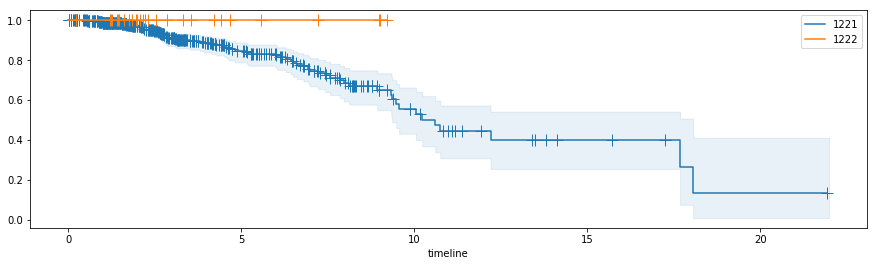

In [31]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1221,1222]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [32]:
# Split largest remaining cluster
# 1223 is mostly Luminal B, some Her2 
# remaining largest cluster (1224) still has significantly different overal survival compared to all other samples
df_summary.loc[[1223,1224]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1223,"None,None",145,58.69,0.99,0.99,0.84,0.85,0.17,0.00,0.00,0.15,0.09,0.76,0.00,8.94,0.84,inf,0.88
1224,"1225,1226",211,58.17,0.98,0.97,0.92,0.90,0.05,0.01,0.04,0.02,0.57,0.12,0.24,17.69,0.00,inf,0.28


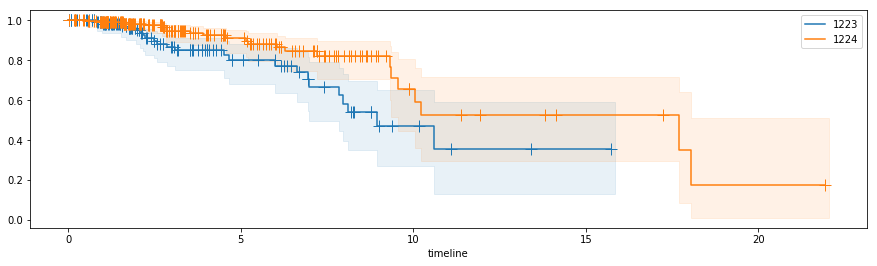

In [33]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1223,1224]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [34]:
# Split largest remaining cluster
# 1225 is mostly Luminal A and Normal with significantly different overal survival
# 1226 is is a mix of Luminal A and B
df_summary.loc[[1225,1226]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1225,"None,None",165,58.05,0.99,0.98,0.93,0.90,0.06,0.00,0.05,0.02,0.56,0.07,0.30,10.05,0.01,inf,0.44
1226,"None,None",26,60.12,0.94,0.96,0.88,0.88,0.00,0.04,0.00,0.00,0.54,0.46,0.00,inf,0.30,14.02,0.89


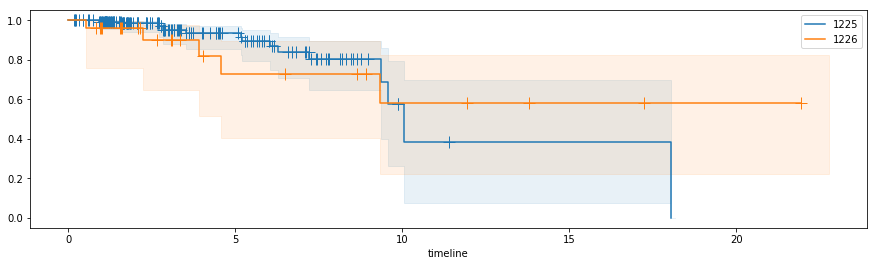

In [35]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1225,1226]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [36]:
# Splitting the Basal, triple negative cluster (1210)
# not a lot of difference between these two subclusters
df_summary.loc[[1215,1216]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1215,"None,None",29,53.76,0.11,0.08,0.17,0.12,0.06,0.48,1.00,0.00,0.00,0.00,0.00,20.42,0.15,inf,0.97
1216,"None,None",52,54.94,0.13,0.16,0.03,0.04,0.03,0.56,1.00,0.00,0.00,0.00,0.00,inf,0.40,inf,0.03


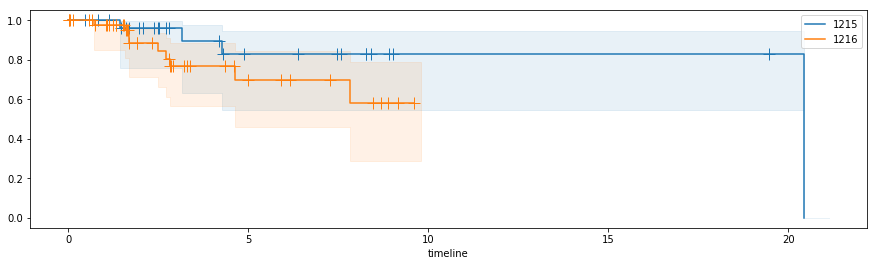

In [37]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1215,1216]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

In [38]:
# Splitting the Normal cluster (1212)
# not much difference except in age at diagnosis and overall survival, 1214 has significantly different OS compared to the rest
df_summary.loc[[1213,1214]].style.format('{:.2f}', subset=df_summary.columns[2:])

,Children,Samples,Age (diagnosis),ER+ fraction,ER+ II fraction,PR+ fraction,PR+ II fraction,HER2+ fraction,TN fraction,Basal (PAM50),Her2 (PAM50),LumA (PAM50),LumB (PAM50),Normal (PAM50),OS median (years),OS p-value,RFS median (years),RFS p-value
1213,"None,None",41,50.68,0.80,0.85,0.60,0.78,0.00,0.02,0.02,0.00,0.00,0.00,0.98,10.05,0.25,inf,0.44
1214,"None,None",43,63.49,nan,0.80,nan,0.66,nan,0.00,0.00,0.00,0.00,0.00,1.00,5.28,0.00,inf,0.58


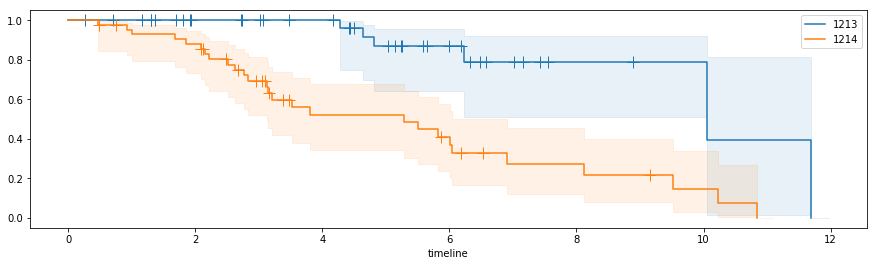

In [39]:
plt.figure(figsize=(15,4))
ax = plt.subplot(111)
for cl in [1213,1214]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

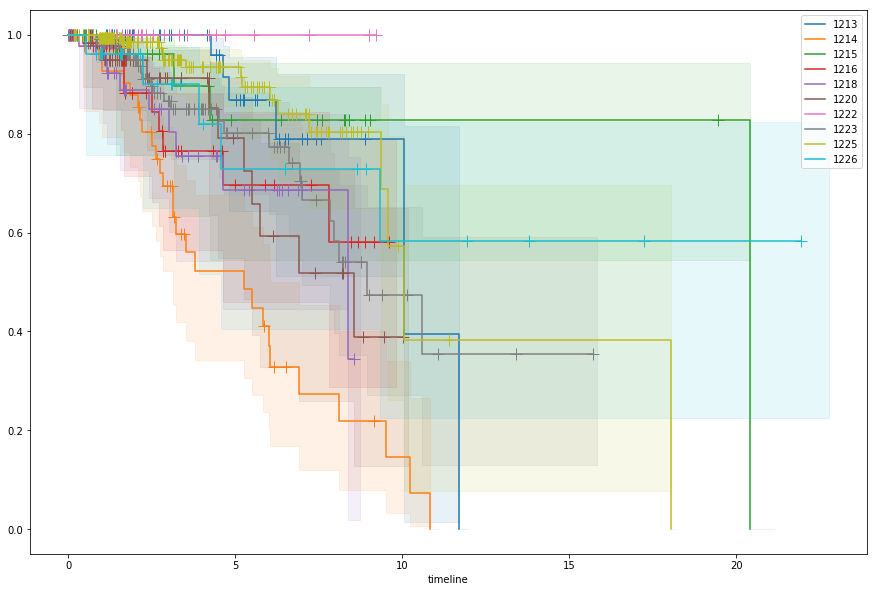

In [40]:
# Kaplan Meier for all final clusters - overall survival
# Colourful, but messy!
plt.figure(figsize=(15,10))
ax = plt.subplot(111)
for cl in [1213,1214,1215,1216,1218,1220,1222,1223,1225,1226]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

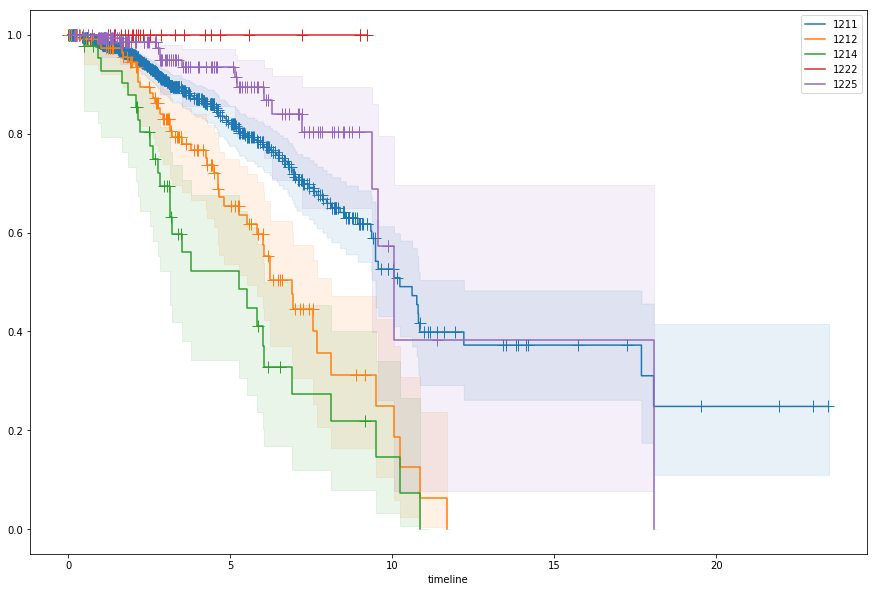

In [41]:
# Some clusters with significantly different OS compared to the rest
# 1211 - lumA, lumB, Her2 (supercluster: all except Normal and Basal)
# 1212 - normal, parent of 1214
# 1214 - normal, worst survival
# 1222 - mixed cluster: all PAM50 types except Basal, but they have excellent survival 
# 1225 - Luminal A
plt.figure(figsize=(15,10))
ax = plt.subplot(111)
for cl in [1211,1212,1214,1222,1225]:
    os[cl].plot(ax=ax, ci_alpha=0.1, ci_legend=True, show_censors=True);

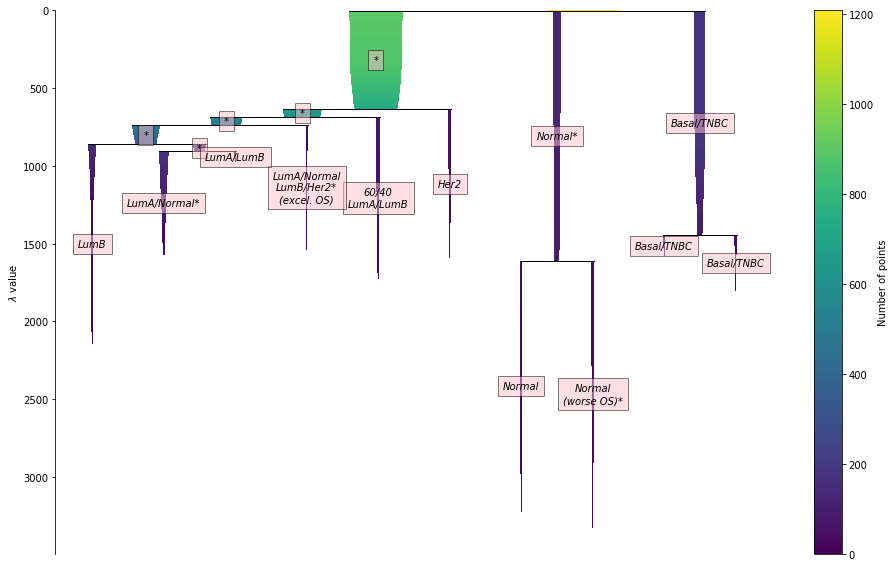

In [43]:
# Plot condensed tree with clusters labelled according to above findings
# * indicates signifcant OS compared to the rest
labels = {1208:'', 1209:'', 1210:'Basal/TNBC', 1211:'*', 1212:'Normal*', 1213:'Normal', 
          1214:'Normal\n(worse OS)*', 1215:'Basal/TNBC', 1216:'Basal/TNBC', 1217:'*', 1218:'Her2', 1219:'*', 
          1220:'60/40\nLumA/LumB', 1221:'*', 1222:'LumA/Normal\nLumB/Her2*\n(excel. OS)', 1223:'LumB', 1224:'*', 
          1225:'LumA/Normal*', 1226:'LumA/LumB'}
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
cluster.condensed_tree_.plot(axis=ax)

cluster_bounds = cluster.condensed_tree_.get_plot_data()['cluster_bounds']
for cl in cluster_bounds:
    x = cluster_bounds[cl]
    width = x[1]-x[0]
    height = x[3]-x[2]
    ax.text(x[0]+width/2, x[2]+height/2, labels[cl], style='italic', 
            horizontalalignment='center', verticalalignment='center',
            bbox={'facecolor':'pink', 'alpha':0.5, 'pad':5})
plt.show()